In [4]:
import sys; sys.path.append('../../')
import numpy as np
import pandas as pd
from DataPreparation.DataPreparation import read_data
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from mlpath import mlquest as mlq
from ModelAnalysis import cross_validation
from utils import load_hyperparameters, save_model, get_metrics, load_model
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
rf_model = 'RandomForest'
from sklearn.linear_model import LogisticRegression
lr_model = 'LogisticRegression'
from sklearn.svm import SVC
svm_model = 'SVM'
model_name = "StackingEnsemble"
mlq.start_quest(model_name, table_dest="../../", log_defs=False)


/opt/anaconda3/envs/M1/lib/python3.9/site-packages/mlpath/mlquest/mlquest.py:66: UserWarning: Attempting to start a run while another one is active may cause data overwrite
  if mlquest.active == True: warnings.warn("Attempting to start a run while another one is active may cause data overwrite")


# <font color="aqua">Stacking Ensemble</font> Model

### Read the data

In [2]:
x_data_d, y_data_d = mlq.l(read_data)(kind='Numerical', standardize=True, split='all-test')
rf_opt_params = load_hyperparameters(rf_model)
svm_opt_params = load_hyperparameters(svm_model)
lr_opt_params = load_hyperparameters(lr_model)

### Initiate model

In [3]:
clf_rf = RandomForestClassifier(**rf_opt_params)
clf_svm = SVC(**svm_opt_params)
clf_log = LogisticRegression(**lr_opt_params)
clf_final = SVC(**svm_opt_params)
clf = mlq.l(StackingClassifier)(estimators=[('svm', clf_svm), ('log', clf_log), ('rf', clf_rf)], final_estimator=clf_final)

### Evaluate Model Bias

In [4]:
clf.fit(x_data_d, y_data_d)
y_pred = clf.predict(x_data_d)
train_metrics = classification_report(y_data_d, y_pred, digits=3)
train_acc, train_wf1 = get_metrics(train_metrics)
print(train_metrics)

              precision    recall  f1-score   support

           0      1.000     0.993     0.996       270
           1      0.993     0.989     0.991       284
           2      0.995     1.000     0.997       574
           3      1.000     1.000     1.000       972

    accuracy                          0.998      2100
   macro avg      0.997     0.996     0.996      2100
weighted avg      0.998     0.998     0.998      2100



In [ ]:
kfold=cross_validation(clf, x_data_d, y_data_d, k=[5], n_repeats=[10], random_state=1)

repeated_10fold_wf1 = kfold.get(f'10-Repeated 10-fold')[0]

10-Repeated 10-fold
0.9912


#### Save Model

In [ ]:
save_model(model_name, clf)

### Tracking

In [ ]:
mlq.log_metrics(train_acc, train_wf1, repeated_10fold_wf1)
mlq.end_quest()
mlq.show_logs(model_name, table_dest="../../", last_k=6)

## Autopsy

In [12]:
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold
from sklearn.metrics import f1_score
from tqdm import tqdm

def CV_Evaluate(model, x_data, y_data):
    """
    Evaluates the performance (F1) of the given model using leave-one-out or repeated KFold cross validation.
    The fact that the function is defined here is a violation to the standards of ths project [Awaiting Fix]
    """
    cval = RepeatedStratifiedKFold(n_splits=3, n_repeats=33, random_state=42)
    f1_scores = []
    for i, j in tqdm(cval.split(x_data, y_data)):           # splits yields indecies of the points in the current split
        x_train, x_val = x_data.iloc[i], x_data.iloc[j]
        y_train, y_val = y_data[i], y_data[j]
        model.fit(x_train, y_train)
        y_pred = model.predict(x_val)
        # compute weighted f1 score
        f1_scores.append(f1_score(y_val, y_pred, average='weighted'))
    mean_f1_score = sum(f1_scores) / len(f1_scores)
    var_f1_score = sum((f1_scores[i] - mean_f1_score)**2 for i in range(len(f1_scores))) / len(f1_scores)
    return mean_f1_score, np.sqrt(var_f1_score), f1_scores

mean_f1, std_f1, f1_scores = CV_Evaluate(clf, x_data_d, y_data_d)

99it [13:15,  8.03s/it]


0.9835404041619511 0.004763322732751002
0.9727595385394641 0.9914449955990273


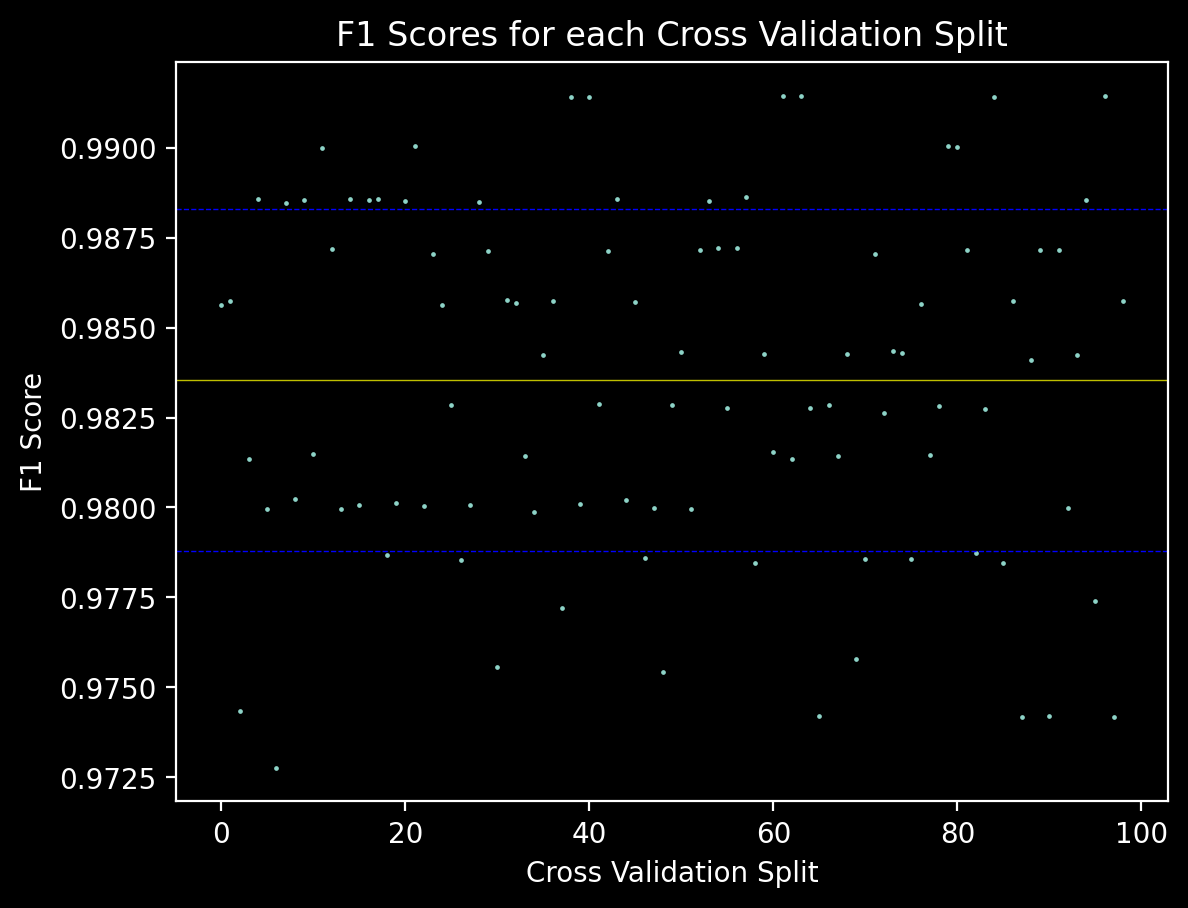

In [15]:
print(mean_f1, std_f1)

# show min and max f1 scores
print(min(f1_scores), max(f1_scores))

# Plot f1_scores with confidence interval for variance using seaborn
import matplotlib.pyplot as plt


# sort the f1_scores descendingly then plot
# dark background
plt.style.use('dark_background')
plt.rcParams['figure.dpi'] = 200
# disable grid
plt.grid(False)
plt.scatter(range(len(f1_scores)), f1_scores, s=0.5)

# plot horizontal line for mean and mean + std
plt.axhline(mean_f1, color='y', linestyle='-', linewidth=0.5)
plt.axhline(mean_f1 + std_f1, color='b', linestyle='--', linewidth=0.5)
plt.axhline(mean_f1 - std_f1, color='b', linestyle='--', linewidth=0.5)



plt.xlabel('Cross Validation Split')
plt.ylabel('F1 Score')
plt.title('F1 Scores for each Cross Validation Split')
plt.show()

In [5]:
x_data_d, y_data_d = read_data(kind='Numerical', standardize=True, split='all')
x_test, y_test = read_data(kind='Numerical', standardize=True, split='test')

rf_opt_params = load_hyperparameters(rf_model)
svm_opt_params = load_hyperparameters(svm_model)
lr_opt_params = load_hyperparameters(lr_model)
clf_rf = RandomForestClassifier(**rf_opt_params)
clf_svm = SVC(**svm_opt_params)
clf_log = LogisticRegression(**lr_opt_params)
clf_final = SVC(**svm_opt_params)
clf = StackingClassifier(estimators=[('svm', clf_svm), ('log', clf_log), ('rf', clf_rf)], final_estimator=clf_final)

clf.fit(x_data_d, y_data_d)

y_pred = clf.predict(x_test)
test_metrics = classification_report(y_test, y_pred, digits=3)
print(test_metrics)



# load StackingEnsemble.ipynb into clf2
clf2 = load_model(model_name)

# predict using clf2
y_pred2 = clf2.predict(x_test)
test_metrics = classification_report(y_test, y_pred2, digits=3)
print(test_metrics)

              precision    recall  f1-score   support

           0      0.964     1.000     0.982        80
           1      0.987     0.940     0.963        83
           2      0.988     0.988     0.988       168
           3      0.997     1.000     0.998       292

    accuracy                          0.989       623
   macro avg      0.984     0.982     0.983       623
weighted avg      0.989     0.989     0.989       623

              precision    recall  f1-score   support

           0      0.964     1.000     0.982        80
           1      1.000     0.940     0.969        83
           2      0.988     1.000     0.994       168
           3      1.000     1.000     1.000       292

    accuracy                          0.992       623
   macro avg      0.988     0.985     0.986       623
weighted avg      0.992     0.992     0.992       623



In [20]:
'''
The final pipeline goes here (competition model) and its evaluation.
'''
import pickle 
import pandas as pd
import os

def read_sample():
    '''
    A read_sample function for when the model is to be evaluated
    '''

    x_data = pd.read_csv('../../DataFiles/test.csv')

    # extract only the numerical features
    cont_feats = [feat for feat in x_data.columns if type(x_data.iloc[0, x_data.columns.get_loc(feat)]) != str]
    # remove the last column (target)
    cont_feats = cont_feats[:-1]
    x_data = x_data[cont_feats]
    for feat in x_data.columns:
        x_data[feat] = x_data[feat].astype(float)

    # standardize the numerical features
    #means=[24.30154547138047, 1.7044246599326598, 86.24393004377106, 2.4137310067340065, 1.9985143434343435, 2.603423063973064, 1.0657414511784513, 0.6401021212121212] 
    #stds=[6.187403093300774, 0.09328631635951697, 25.765476944060072, 0.5586174649270286, 0.6404876859634282, 0.8226938923003604, 0.8170331197353868, 0.5959943002074906,0.98989898989899]
    #for i,feat in enumerate(x_data.columns):
    #    x_data[feat] = (x_data[feat] - means[i])/stds[i]
    
    #means = [24.29041986,  1.70160229, 86.54228975,  2.42191212,  2.00512017,  2.68210374, 1.02310583,  0.65067154] 
    #stds = [ 6.32308119,  0.09465379, 26.27827729,  0.5407114,   0.62030746,  0.7907506, 0.84484037,  0.6051992 ]
    #for i,feat in enumerate(x_data.columns):
    #    x_data[feat] = (x_data[feat] - means[i])/stds[i]
    
    #print(means, stds)
    #means = np.load('../../Saved/means.npy')
    #stds = np.load('../../Saved/stds.npy')
    #for i, feat in enumerate(x_data.columns):
    #    if type(x_data.iloc[0, x_data.columns.get_loc(feat)]) != str:
    #        x_data[feat] = (x_data[feat] - means[i])/stds[i]
    return x_data


def predict(model, x_test):
    '''
    Predicts the target variable for the given data.
    '''
    y_pred = model.predict(x_test)
    return y_pred


# Read the data
x_test = read_sample()

# Load the model
model = load_model('StackingEnsemble')

# Predict the target variable
y_pred = predict(model, x_test)

# print WF1 using y_pred and y_test
test_metrics = classification_report(y_test, y_pred, digits=3)
print(test_metrics)

# write the predictions to a txt file
with open('preds.txt', 'w') as f:
    for i, item in enumerate(y_pred):
        if i == len(y_pred) - 1:
            f.write("%s" % item)
        else:
            f.write("%s\n" % item)

              precision    recall  f1-score   support

           0      0.920     1.000     0.958        80
           1      1.000     0.807     0.893        83
           2      0.949     0.994     0.971       168
           3      0.997     1.000     0.998       292

    accuracy                          0.973       623
   macro avg      0.966     0.950     0.955       623
weighted avg      0.974     0.973     0.972       623

